## АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ

#### Туристическая фирма планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные.

#### Предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку.

#### Необходимо убедиться, что A/B-тестирование было проведено корректно, проверить факт стабилизации метрик и обоснованно ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?

#### Импортируем необходимые библиотеки и функции

In [215]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import t

#### Считываем данные из файла csv

In [177]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


### Анализ структуры данных и их предобработка:

#### Исследуем структуру данных

In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


*Пропусков нет.* 

#### Преобразуем столбец: дата посещения сайта к временному типу данных.

In [179]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

#### Убедимся в том что длительность проведения A/B-тестирования в каждой из групп совпадают

In [180]:
# Получим даты проведения теста в группе А
date_a = set(data[data['date']=='A'].date.values)
# Получим даты проведения теста в группе В
date_b = set(data[data['date']=='B'].date.values)
# Убедимся, что все даты проведения теста в группах А и В совпадают
if set(date_a).issubset(date_b):
    print('Все даты посещения сайта группой А совпадают с группой В')
else:
    print('Не все даты посещения сайта группой А совпадают с группой В')


Все даты посещения сайта группой А совпадают с группой В


#### Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе группы. Если да, исключим пользователей, оказавшихся в обеих группах.

In [181]:
# Получим множество id пользователей группы А
user_ids_a = set(data[data['group']=='A'].user_id.values)
# Получим множество id пользователей группы В
user_ids_b = set(data[data['group']=='B'].user_id.values)
# Получим объединение множеств пользователей группы А и В
user_ids_ab_union = set(user_ids_a).union(user_ids_b)
len_user_ids_ab_union = len(user_ids_ab_union) 
print('ОБщее количество пользователей оказавшихся в группах А и В:', len_user_ids_ab_union)
# Получим пересечение множеств пользователей группы А и В
user_ids_ab_intersection = set(user_ids_a).intersection(user_ids_b)
len_user_ids_ab_intersection = len(user_ids_ab_intersection)
print('Количество пользователей оказавшихся обеих группах:', len_user_ids_ab_intersection)
percentage_users_ids_ab_intersection = round((len_user_ids_ab_intersection / len_user_ids_ab_union) * 100, 2)
print(f'Процент пользователей оказавшихся обеих группах: {percentage_users_ids_ab_intersection}%')
# Получим выборку, в которой отсутствуют пользователи находящиеся в группах А и В
data_claened = data[~data.user_id.isin(user_ids_ab)]
print('Кол-во строк в выборке до исключения пользователей, оказавшихся в обеих группах:',
         data.shape[0])
print('Кол-во строк в выборке после исключения пользователей, оказавшихся в обеих группах:',
         data_claened.shape[0])

ОБщее количество пользователей оказавшихся в группах А и В: 290584
Количество пользователей оказавшихся обеих группах: 1895
Процент пользователей оказавшихся обеих группах: 0.65%
Кол-во строк в выборке до исключения пользователей, оказавшихся в обеих группах: 294478
Кол-во строк в выборке после исключения пользователей, оказавшихся в обеих группах: 290688


### Первичный анализ результатов A/B-тестирования:

#### Рассчитаем вспомогательные показатели для контрольной и тестовой групп:

- количество посещений сайта;
- суммарное количество совершённых покупок;
- сумма всех покупок.

In [182]:
grouped_data = data_claened.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum',
}).reset_index().rename(columns={   'user_id': 'users_count',
                                    'purchase': 'number_purchases',
                                    'price': 'sum_purchases'})
grouped_data.head()

,group,users_count,number_purchases,sum_purchases
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


*Количество посещений обоих вариантов посадочной страницы сопоставимо. Выборки сбалансированы.*

#### В каждой из групп рассчитаем ключевые показатели:

- конверсия;
- средний чек.

In [183]:
# Рассчитаем конверсию для каждой группы
grouped_data['conversion'] = grouped_data['number_purchases'] / grouped_data['users_count'] * 100
# Рассчитаем средний чек для каждой группы
grouped_data['average_check'] = grouped_data['sum_purchases'] / grouped_data['number_purchases']
grouped_data.head()

,group,users_count,number_purchases,sum_purchases,conversion,average_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


*Делая первичные выводы о результатах A/B-тестирования, можно сказать, что по конверсии, на первый взгляд, вариант А эффективнее варианта B, по среднему чеку, на первый взгляд, вариант B эффективнее варианта А.*

#### Сравним варианты A/B по покупательской способности каждого из туров. Для этого построим сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура.

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


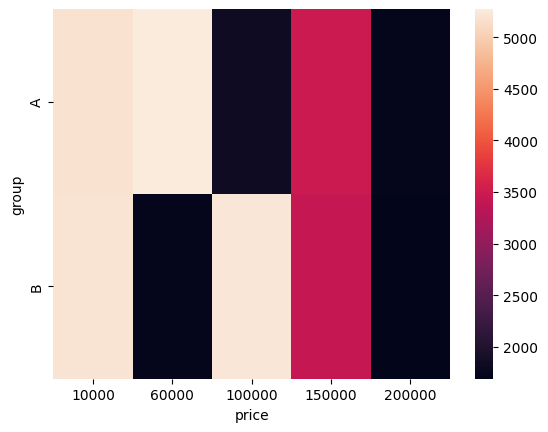

In [184]:
pivot_table = pd.pivot_table(data_claened[data_claened['price']>0], 
        values='purchase', index='group', columns='price', aggfunc='sum')
display(pivot_table)
sns.heatmap(pivot_table);

*По турам в Турцию покупательская способность участников группы А выше, чем покупательская способность участников группы B. По турам в Тайланд покупательская способность участников группы В выше, чем покупательская способность участников группы А. По всем остальным турам покупательская способность участников групп А и В практически одинакова.*

### Анализ данных на предмет стабилизации метрик

#### Сгруппируем данные по дате и группе тестирования и построим таблицу с ежедневными данными результатов проведения A/B-тестирования. В каждой группе вычислим ежедневные показатели:

- количество посещений страницы;
- количество покупок;
- сумму покупок.



In [185]:
daily_data = data_claened.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum',
}).reset_index().rename(columns={   'user_id': 'users_count',
                                    'purchase': 'number_purchases',
                                    'price': 'sum_purchases'})
daily_data.head()

,date,group,users_count,number_purchases,sum_purchases
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


#### Добавим в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и о ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

In [186]:
daily_data['conversion'] = daily_data['number_purchases'] / daily_data['users_count'] * 100
daily_data['average_check'] = daily_data['sum_purchases'] / daily_data['number_purchases']
daily_data.head()

,date,group,users_count,number_purchases,sum_purchases,conversion,average_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


#### Рассчитаем кумулятивные показатели:

- кумулятивное количество посещений страницы;
- кумулятивное количество покупок;
- кумулятивную сумму покупок.

In [187]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых покупок
daily_data['cum_number_purchases'] = daily_data.groupby(['group'])['number_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
daily_data['cum_sum_purchases'] = daily_data.groupby(['group'])['sum_purchases'].cumsum()
display(daily_data[['date', 'group', 'cum_users_count', 'cum_number_purchases', 'cum_sum_purchases']].head(6))

,date,group,cum_users_count,cum_number_purchases,cum_sum_purchases
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,9450,1107,91410000
3,2021-01-03,B,9480,1099,95620000
4,2021-01-04,A,16016,1906,155660000
5,2021-01-04,B,16016,1863,163650000


#### На основе полученных кумулятивных показателей вычислим кумулятивную конверсию и кумулятивный средний чек.

In [188]:
daily_data['cum_conversion'] = daily_data['cum_number_purchases']/daily_data['cum_users_count'] * 100
daily_data['cum_average_check'] = daily_data['cum_sum_purchases']/daily_data['cum_users_count']
display(daily_data[['date', 'group', 'cum_conversion', 'cum_average_check']].head(6))

,date,group,cum_conversion,cum_average_check
0,2021-01-02,A,12.578837,10304.835319
1,2021-01-02,B,12.058721,10367.004544
2,2021-01-03,A,11.714286,9673.015873
3,2021-01-03,B,11.592827,10086.497890
4,2021-01-04,A,11.900599,9719.030969
5,2021-01-04,B,11.632118,10217.907093


In [189]:
import warnings # To suppress some warnings
 
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

#### Построим кумулятивные графики конверсии и среднего чека в каждой группе по дням.

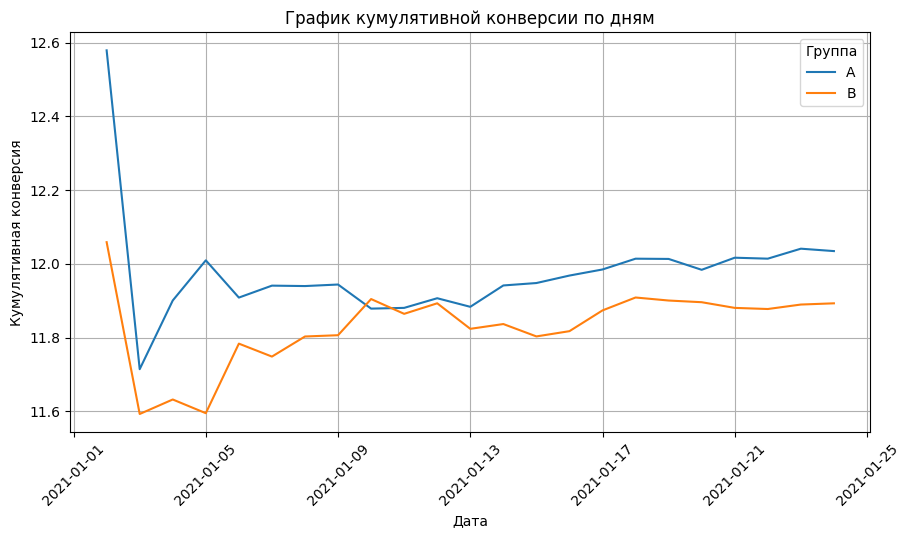

In [190]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём подпись к легенде
plt.legend(title='Группа')
# задаём подпись к оси абцисс
ax.set_xlabel('Дата')
# задаём подпись к оси ординат
ax.set_ylabel('Кумулятивная конверсия')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

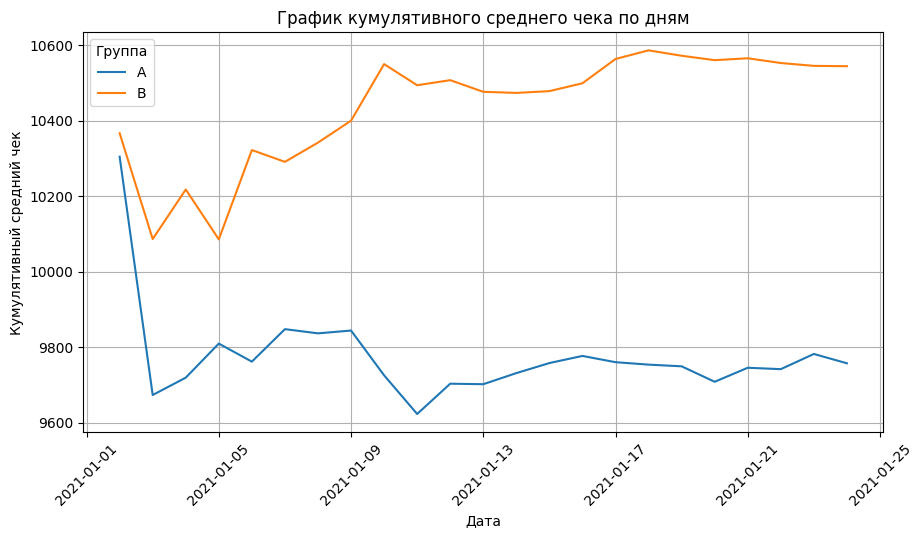

In [191]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_average_check', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём подпись к легенде
plt.legend(title='Группа')
# задаём подпись к оси абцисс
ax.set_xlabel('Дата')
# задаём подпись к оси ординат
ax.set_ylabel('Кумулятивный средний чек')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

*На основании стабилизированных кумулятивных графиков конверсии и среднего чека мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателями в группах. Назвать A/B-тест завершённым нельзя, необходимо провести статистические тесты.
Соотношения кумулятивных показателей в каждой группе соответсвует перпичному результату А/В-тестирования, т.е. по конверсии, на первый взгляд, вариант А эффективнее варианта B, по среднему чеку, на первый взгляд, вариант B эффективнее варианта А.*

### Статистический анализ результатов A/B-тестирования

*Мы убедились, что A/B-тестирование было проведено корректно (в каждой группе собрано достаточно данных и длительность теста одинакова, группы сбалансированы и отсутствуют пересечения в группах). Фиксируем факт стабилизации метрик (метрики стабилизировались во времени, их кумулятивный вариант переходит в прямую на графиках). Визуально оценили интересующие нас метрики в каждой из групп, сделали первичные выводы. Теперь нам необходимо обоснованно подтвердить первичные выводы с помощью статистических тестов, т.е. ответить на вопрос: является ли разница между метриками групп статистически значимой? И тем самым ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?*

#### Сформулируем статистические гипотезы, соответствующие поставленным бизнес-вопросам, и выберем статистический тест для их проверки.

*Мы видим, судя по первичному анализу, что показатели конверсии в обеих группах практически не отличаются, с небольшим перевесом в группе А. Поэтому мы просто подветдим с помощью статистического теста, что статистической разницы нет, сформулируем следующую двустороннюю гипотезу:* 
- *Нулевая гипотеза: конверсии в группах A и B равны*
- *Альтернативная гипотеза: конверсии в группах A и B не равны.*

*В нашем случае соблюдаются все условия проведения A/B-теста, таким образом для проверки статистической значимости разницы конверсий в группах будет достаточно использовать Z-тест для пропорций.*

*Мы видим по графику кумулятивного среднего чека по дням, что данный показатель в определенной степени выше в группе В. Поэтому проверим гипотезу о том, что вариант В посадочной страницы более предпочтителен по метрике ежедневного среднего чека. Т.е. посадачная старинца из варианта В более привлекательна для посетителей,  следовательно, они купили больше туров. Уровень значимости равен 0.05. Сформируем левостороннюю гипотезу:*
- *Нулевая гипотеза: распределение, лежащее в основе среднего чека в группе А, статистически больше либо равно распределению, лежащему в основе среднего чека в группе B*
- *Альтернативная гипотеза: распределение, лежащее в основе среднего чека в группе А, статистически меньше распределения, лежащего в основе среднего чека в группе B.*

*Итак, если распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом, если распределение не нормально, тогда придется применить U-тест, тобы сравнить средней чек в группах.*

#### С помощью аппарата статистических тестов определим:

- Есть ли статистическая разница между конверсиями в группах А и B?
- Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

*Сначала подготовим данные к проведению статистического Z-теста для пропорций. Для этого нам нужно рассчитать количество пользователей, совершивших конверсию, и общее количество пользователей в каждой группе.*

*Cгруппируем таблицу data по признаку группы и рассчитаем количество «успехов» и общее количество наблюдений для каждой группы.*

In [192]:
converted_piv= data_claened.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17487,145307
B,17290,145381


*Зададим уровень значимости и будем сравнивать полученное p-value с ним.*

In [193]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='two-sided' # двусторонняя альтернативная гипотеза
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


*Итак, мы получили p-value, которое больше, чем заданный уровень значимости 0.05, а значит, мы должны принять нулевую гипотезу о равенстве конверсий.*

*Что это значит для нас и для бизнеса?*

*Так как Z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза не подтверждается статистически.*

*Переводим на язык бизнеса: разницы между вариантами дизайна посадочной страницы нет — они одинаково эффективны по метрике конверсии.*


*По предварительным подсчётам, средний чек в группе B выше, чем в группе A. Однако делать выводы ещё рано — необходимо определить статистическую значимость полученных результатов.*

*Построим гистограмму среднего чека в каждой из групп:*

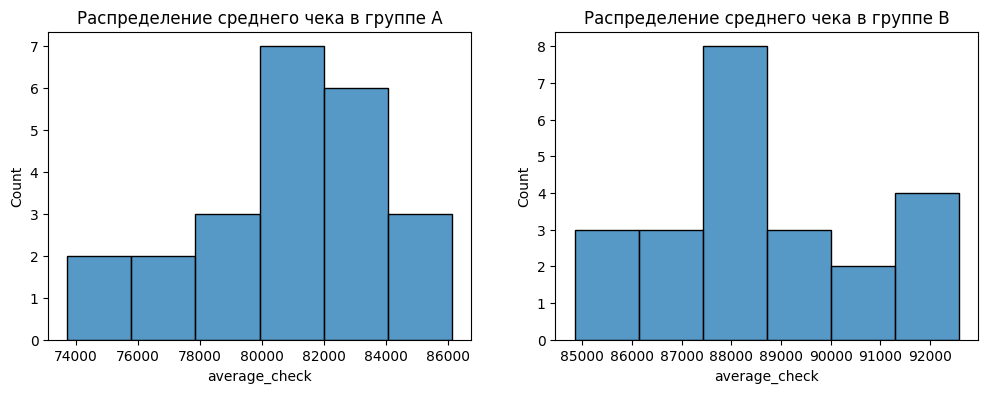

In [194]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='average_check', data=daily_data[daily_data['group']=='A'], ax=axes[0])
sns.histplot(x='average_check', data=daily_data[daily_data['group']=='B'], ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

*Гистограммы слабо напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро — Уилка.*

*Зададим уровень значимости и проверим гипотезу о нормальности каждого из распределений (нулевая гипотеза — распределение нормальное, альтернативная — распределение отлично от нормального):*

In [195]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
average_check_a = daily_data[daily_data['group']=='A'].average_check
average_check_b = daily_data[daily_data['group']=='B'].average_check
shapiro_result_a = shapiro(average_check_a)
shapiro_result_b = shapiro(average_check_b)
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


*Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом, чтобы сравнить среднее время посещения сайта в группах.*

In [196]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=average_check_a,
    b=average_check_b,
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value: 0.0
# Отвергаем нулевую гипотезу в пользу альтернативной

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


*Итак, в результате проведения T-теста мы получили p-value = 0, что меньше, чем уровень значимости. Это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной.*

*Что это значит для нас и для бизнеса?*

*Так как истинные значения средних чеков в группе В больше чем в группе А (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза подтверждается статистически.*

*Переводим на язык бизнеса: На основе данных мы видим, что вариант В посадочной страницы более предпочтителен по метрике ежедневного среднего чека.*

#### Подкрепим результаты статистических тестов, построив 95 % доверительные интервалы для:

- конверсий в каждой из групп;
- разницы конверсий в группах;
- ежедневного среднего чека в каждой из групп.

*Для удобства создадим отдельные таблицы для каждой из групп пользователей:*

In [197]:
# фильтруем данные группы А
data_claened_a = data_claened[data_claened['group'] == 'A']
# фильтруем данные группы B
data_claened_b = data_claened[data_claened['group'] == 'B']

*Оформим расчёт в виде функции: объявим функцию proportion_conf_interval(). У данной функции будет три аргумента: x_p — выборочная пропорция, n — размер выборки и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой.*

In [198]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

*Теперь применим нашу функцию к данным группы А и группы B, результат умножим на 100 % и округлим до сотых:*

In [200]:
# строим доверительный интервал для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=data_claened_a['purchase'].mean(), # выборочная пропорция
    n=data_claened_a['user_id'].count() # размер выборки
)

# строим доверительный интервал для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=data_claened_b['purchase'].mean(), # выборочная пропорция
    n=data_claened_b['user_id'].count() # размер выборки
)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))


Доверительный интервал для конверсии в группе А: (11.87, 12.2)
Доверительный интервал для конверсии в группе B: (11.73, 12.06)


*Создадим функцию diff_proportion_conf_interval() со следующими аргументами: x_p — список из выборочных пропорций для групп А и B соответственно,  n — список из размеров выборки для групп А и B соответственно, и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.*

In [201]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [202]:
# размеры выборок групп А и B
n = [data_claened_a['user_id'].count(), data_claened_b['user_id'].count()]
# выборочная пропорция групп A и B
x_p = [data_claened_b['purchase'].mean(), data_claened_b['purchase'].mean()]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format(
    (round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.24, 0.24)


*Итак, что можно сказать теперь? Построенный доверительный интервал конверсий с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.24 % до 0.24 %. Это значит, что варианты А и B равнозначны по метрике конверсии.*

*Построим доверительный интервал для среднего чека при неизвестном истинном стандартном отклонении с надёжностью в 95 %.*

*Для удобства создадим отдельные таблицы для каждой из групп пользователей:*

In [207]:
# фильтруем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# фильтруем данные группы B
daily_data_b = daily_data[daily_data['group'] == 'B']

*Итак, зададим необходимые для решения задачи переменные групп А и B:*

In [221]:
n = daily_data_a.shape[0] # размер выборки групп А и В одинаковый
k = n - 1 # число степеней свободы
x_mean_a = daily_data_a.average_check.mean() # выборочное среднее
x_std_a = daily_data_a.average_check.std() # выборочное стандартное отклонение
x_mean_b = daily_data_b.average_check.mean() # выборочное среднее
x_std_b = daily_data_b.average_check.std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

*Найдем значение t-критического для любого уровня значимости можно, используя функцию t.ppf() из модуля scipy.stats. Для этого в функцию передаётся интересующий уровень значимости () и число степеней свободы (). Аналогично z-критическому функция возвращает отрицательный модуль t-критического, поэтому мы берём его со знаком минус:*

In [223]:
t_crit = -t.ppf(alpha/2, k) # t-критическое
print(t_crit)

2.0738730679040147


*Теперь составим доверительный интервал для истинного среднего чека для групп А и В. Давайте напишем функцию для вычисления доверительного интервала для среднего — t_mean_conf_interval(). Округлим результат и выведем на экран:*

In [224]:
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# cтроим доверительный интервал для среднего при неизвестном СКО
lower_bound_a, upper_bound_a = t_mean_conf_interval(x_mean_a, x_std_a, n)
lower_bound_b, upper_bound_b = t_mean_conf_interval(x_mean_b, x_std_b, n)
# выводим результат
print('Доверительный интервал среднего чека в группе А: {}'.format(
    (round(lower_bound_a), round(upper_bound_a))))
print('Доверительный интервал среднего чека в группе B: {}'.format(
    (round(lower_bound_b), round(upper_bound_b))))

Доверительный интервал среднего чека в группе А: (79630, 82308)
Доверительный интервал среднего чека в группе B: (87626, 89526)


#### Проинтерпретируем построенные доверительные интервалы для конверсий и ежедневного среднего чека в группах. 

*Из полученного доверительного интервала разницы конверсий можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.*

*Перекрытия между доверительными интервалами среднего чека для групп А и В не зафиксировано. Это в очередной раз подтверждает, что существует статистически значимая разница в данном показателе между группами А и В. А если быть точнее то, в группе В средний чек выше.*

### Сделаем общий вывод по результатам A/B-теста

*Оба варианта дизайна посадочной страницы одинаково эффективны по метрике конверсии. По метрике ежедневного среднего чека наиболее эффективен вариант В. Данный вывод основан на результатах первичного и статистического анализов.*